In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Load datasets
train_data = pd.read_csv('train2_binary.csv')
val_data = pd.read_csv('valid2_binary.csv')
test_data = pd.read_csv('test2_binary.csv')

In [3]:
# Inspect data to identify relevant columns
print(train_data.head())

   label                                          statement  __index_level_0__
0    0.0  Says the Annies List political group supports ...                0.0
1    1.0  When did the decline of coal start? It started...                1.0
2    1.0  Hillary Clinton agrees with John McCain "by vo...                2.0
3    0.0  Health care reform legislation is likely to ma...                3.0
4    1.0  The economic turnaround started at the end of ...                4.0


In [4]:
# Extract features and labels
X_train = train_data['statement']
y_train = train_data['label']
X_val = val_data['statement']
y_val = val_data['label']
X_test = test_data['statement']
y_test = test_data['label']

# Combine train and validation data for Grid Search
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

In [5]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_combined_vectorized = vectorizer.fit_transform(X_combined)
X_test_vectorized = vectorizer.transform(X_test)

In [8]:
# Perform Randomized Search to find best hyperparameters for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

start_rf = time.time()
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=30,
                                      cv=5,
                                      scoring='accuracy',
                                      n_jobs=-1,
                                      random_state=42)

random_search_rf.fit(X_combined_vectorized, y_combined)
end_rf = time.time()
print(f"Random Forest Randomized Search Time: {end_rf - start_rf:.2f} seconds")

Random Forest Randomized Search Time: 944.19 seconds


In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')

    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return acc, f1, precision, recall


=== RandomForest Performance ===
Accuracy: 0.6290
F1-Score: 0.5850
Precision: 0.6471
Recall: 0.6290

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.28      0.39       553
           1       0.62      0.90      0.73       714

    accuracy                           0.63      1267
   macro avg       0.65      0.59      0.56      1267
weighted avg       0.65      0.63      0.58      1267



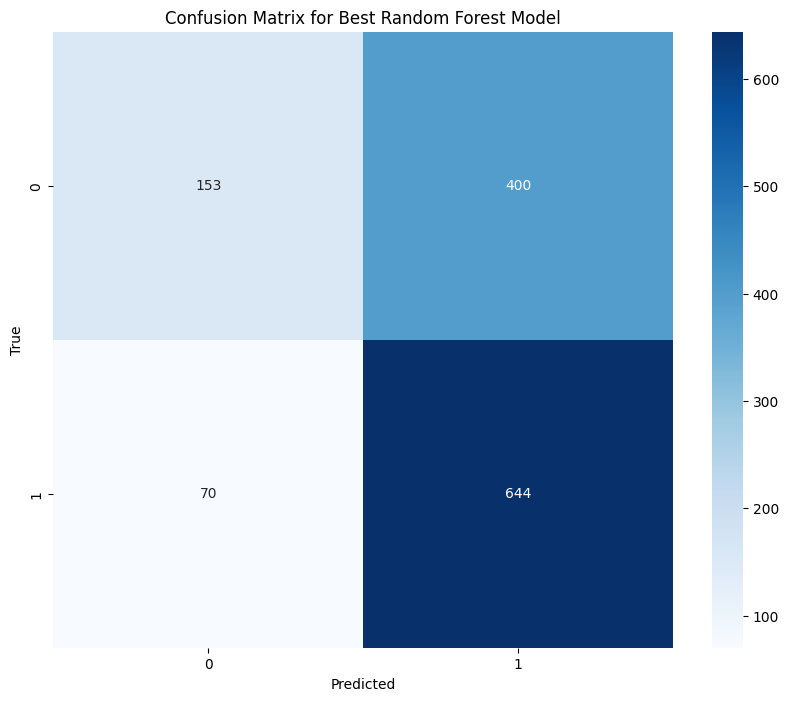


Random Forest Results:
{'Model': 'RandomForest', 'Best Params': {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 50}, 'CV Accuracy': 0.6095988114605929, 'Test Accuracy': 0.6290449881610103, 'Test F1-Score': 0.5849858413386257, 'Precision': 0.6470791931041887, 'Recall': 0.6290449881610103}


In [12]:
# Extract best estimator for Random Forest
best_rf = random_search_rf .best_estimator_
cv_accuracy_rf = random_search_rf .best_score_
y_test_pred_rf = best_rf.predict(X_test_vectorized)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_test_pred_rf, average='weighted')

print(f"\n=== RandomForest Performance ===")
print(f"Accuracy: {acc_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf))

cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.show()

rf_results = {
    'Model': 'RandomForest',
    'Best Params': random_search_rf .best_params_,
    'CV Accuracy': cv_accuracy_rf,
    'Test Accuracy': acc_rf,
    'Test F1-Score': f1_rf,
    'Precision': precision_rf,
    'Recall': recall_rf
}

print("\nRandom Forest Results:")
print(rf_results)